In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jacobian, jit, vmap
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

In [2]:
# load the oscillator trajectory
with np.load('osctraj3.npz') as data:
    xtrue = data['arr_0']

print(xtrue.shape)
numtraj, dimdata, allsteps = xtrue.shape

# need to define global constant dt
dt = 4.0/400

# simulated observations with percentage of noise added
# y = xtrue.copy()
pctnoise = 1.0
myscale = (pctnoise/100.0)*np.mean(np.std(xtrue,axis=2),axis=0)
nsteps = 201
y = np.zeros((numtraj, dimdata, nsteps))
for i in range(dimdata):
    y[:,i,:nsteps] = xtrue[:,i,:nsteps] + np.random.normal(loc=0, scale=myscale[i], size=[numtraj*nsteps]).reshape((numtraj, nsteps))

print(y.shape)

(100, 6, 401)
(100, 6, 201)


In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

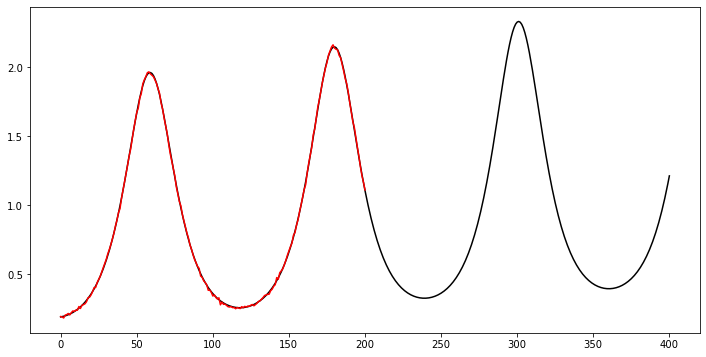

In [4]:
plt.figure(figsize=(12,6))
plt.plot(xtrue[0,0,:],'k')
plt.plot(y[0,0,:],'r')
plt.show()

In [5]:
# def all_products2(a):
#     x, y = np.triu_indices(len(a), 1)
#     return np.concatenate([a, a[x] * a[y]])

# following function assumes GLOBALS degrees and whichdim have been defined
def all_products_maxdeg(a, m, ndim):
    degrees = flatten([[i]*ndim for i in range(1,m+1)])
    whichdim = list(range(ndim))*m
    x, y = jnp.triu_indices(len(a), 1)
    x2 = []
    y2 = []
    for i in range(len(x)):
        if degrees[x[i]] + degrees[y[i]] <= m:
            if whichdim[x[i]] != whichdim[y[i]]:
                x2.append(x[i])
                y2.append(y[i])
    return jnp.concatenate([a, a[x2] * a[y2]])

def flatten(x):
    return [item for sublist in x for item in sublist]

def all_productsCHAR(a):
    x, y = np.triu_indices(len(a), 1)
    return [a[x[i]] + '*' + a[y[i]] for i in range(len(x))] 

# following function assumes GLOBALS degrees and whichdim have been defined
def all_products_maxdegCHAR(a, m, ndim):
    degrees = flatten([[i]*ndim for i in range(1,m+1)])
    whichdim = list(range(ndim))*m
    x, y = np.triu_indices(len(a), 1)
    x2 = []
    y2 = []
    for i in range(len(x)):
        if degrees[x[i]] + degrees[y[i]] <= m:
            if whichdim[x[i]] != whichdim[y[i]]:
                x2.append(x[i])
                y2.append(y[i])
    return [a[x2[i]] + '*' + a[y2[i]] for i in range(len(x2))] 


In [6]:
def getxi(xx, maxpow):
    ndim = xx.shape[0]
    mypow = lambda i : jnp.power(xx, i)
    allpow = jnp.reshape(jnp.array(list(map(mypow, jnp.arange(1,(maxpow+1))))),(maxpow*ndim,))
    allprodm = all_products_maxdeg(allpow, maxpow, ndim)
    return allprodm

In [7]:
xest = jnp.array(y)
print(xest.shape)

(100, 6, 201)


/home/hbhat/.conda/envs/myjax/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [8]:
jgetxi = jit(getxi, static_argnums=(1,))
print(jgetxi(xest[0,:,0], 3).shape)

(63,)


In [9]:
getxivec = vmap(getxi, in_axes=(1, None), out_axes=0)
# print(getxivec(xest[:,1:-1], 3).shape)

In [10]:
getximat = vmap(getxivec, in_axes=(0,None), out_axes=0)
print(getximat(xest[:,:,1:-1], 3).shape)

(100, 199, 63)


In [11]:
jgetxivec = jit(vmap(getxi, in_axes=(0, None), out_axes=0), static_argnums=(1,))
print(jgetxivec(xest[:,:,0], 3).shape)

jgetximat = jit(getximat, static_argnums=(1,))
print(jgetximat(xest[:,:,1:-1], 3).shape)

(100, 63)
(100, 199, 63)


In [12]:
jgradgetxi = jit(jacobian(getxi, 0), static_argnums=(1,))
jgradgetxi(xest[0,:,0], 3).shape

(63, 6)

In [13]:
jgradgetxivec = jit(vmap(jacobian(getxi, 0), in_axes=(1, None), out_axes=0), static_argnums=(1,))
jgradgetxivec(xest[0,:,1:-1], 3).shape

(199, 63, 6)

In [14]:
jgradgetximat = jit(vmap(vmap(jacobian(getxi, 0), in_axes=(1, None), out_axes=0), in_axes=(0, None), out_axes=0), static_argnums=(1,))
jgradgetximat(xest[:,:,1:-1], 3).shape

(100, 199, 63, 6)

In [15]:
# plt.plot((xtrue[0,2:] - xtrue[0,:-2])/(2*dt))
# plt.plot(-np.sin(tvec))
# plt.show()

In [16]:
intercept = False

def sparsereg(xest, maxpow=2, thresh=0.2, maxthresh=50):
    # centered difference approximation of derivative
    xdot = ((xest[:,2:] - xest[:,:-2])/(2*dt)).T
    # get rid of first and last observation to match second dimension of xdot
    bigxi = jgetxivec(xest[:,1:-1], maxpow)

    # iterated sparse regression
    # do this by dimension
    if intercept:
        beta = np.zeros((1 + bigxi.shape[1], xest.shape[0]))
        for curdim in range(xest.shape[0]):
            goodcols = np.array(list(range(bigxi.shape[1])))
            doneFlag = False
            while doneFlag == False:
                reg = LinearRegression().fit(bigxi[:,goodcols], xdot[:,curdim])
                newgoodcols = goodcols[np.where(np.abs(reg.coef_) >= thresh)[0]]
                if len(goodcols) == len(newgoodcols):
                    if np.sum(np.abs(goodcols - newgoodcols)) == 0:
                        doneFlag = True
                        beta[0, curdim] = reg.intercept_
                        beta[1 + goodcols, curdim] = reg.coef_
                goodcols = newgoodcols

        bigxi = np.hstack([np.ones((bigxi.shape[0], 1)), bigxi])
    else:
        beta = np.zeros((bigxi.shape[1], xest.shape[0]))
        for curdim in range(xest.shape[0]):
            goodcols = np.array(list(range(bigxi.shape[1])))
            doneFlag = False
            while doneFlag == False:
                reg = LinearRegression(fit_intercept=False).fit(bigxi[:,goodcols], xdot[:,curdim])
                newgoodcols = goodcols[np.where(np.abs(reg.coef_) >= thresh)[0]]
                if len(goodcols) == len(newgoodcols):
                    if np.sum(np.abs(goodcols - newgoodcols)) == 0:
                        doneFlag = True
                        beta[goodcols, curdim] = reg.coef_
                goodcols = newgoodcols
    
    return beta, bigxi


In [17]:
# xdot = jnp.swapaxes((xest[:,:,2:] - xest[:,:,:-2])/(2*dt),1,2).reshape((numtraj*(nsteps-2), dimdata))
# # get rid of first and last observation to match second dimension of xdot
# bigxi = jgetximat(xest[:,:,1:-1], maxpow).reshape((numtraj*(nsteps-2), -1))

# print(xdot.shape)
# print(bigxi.shape)
# goodcols = np.array(list(range(bigxi.shape[1])))


In [18]:
def sparseregmulttraj(xest, maxpow=2, thresh=0.2, maxthresh=50):
    # centered difference approximation of derivative
    xdot = jnp.swapaxes((xest[:,:,2:] - xest[:,:,:-2])/(2*dt),1,2).reshape((numtraj*(nsteps-2), dimdata))
    # get rid of first and last observation to match second dimension of xdot
    bigxi = jgetximat(xest[:,:,1:-1], maxpow).reshape((numtraj*(nsteps-2), -1))

    # iterated sparse regression
    # do this by dimension
    if intercept:
        beta = np.zeros((1 + bigxi.shape[1], xest.shape[1]))
        for curdim in range(xest.shape[1]):
            goodcols = np.array(list(range(bigxi.shape[1])))
            doneFlag = False
            while doneFlag == False:
                reg = LinearRegression().fit(bigxi[:,goodcols], xdot[:,curdim])
                newgoodcols = goodcols[np.where(np.abs(reg.coef_) >= thresh)[0]]
                if len(goodcols) == len(newgoodcols):
                    if np.sum(np.abs(goodcols - newgoodcols)) == 0:
                        doneFlag = True
                        beta[0, curdim] = reg.intercept_
                        beta[1 + goodcols, curdim] = reg.coef_
                goodcols = newgoodcols

        bigxi = np.hstack([np.ones((bigxi.shape[0], 1)), bigxi])
    else:
        beta = np.zeros((bigxi.shape[1], xest.shape[1]))
        for curdim in range(xest.shape[1]):
            goodcols = np.array(list(range(bigxi.shape[1])))
            doneFlag = False
            while doneFlag == False:
                reg = LinearRegression(fit_intercept=False).fit(bigxi[:,goodcols], xdot[:,curdim])
                newgoodcols = goodcols[np.where(np.abs(reg.coef_) >= thresh)[0]]
                if len(goodcols) == len(newgoodcols):
                    if np.sum(np.abs(goodcols - newgoodcols)) == 0:
                        doneFlag = True
                        beta[goodcols, curdim] = reg.coef_
                goodcols = newgoodcols
    
    return beta, bigxi


In [19]:
# test whether dims work out
# test = jgetximat(xest, maxpow)
# print(test.shape)
# betahat, bigxi = sparseregmulttraj(y, maxpow=3, thresh=0.1)
# print(betahat.shape)
# frhs = jnp.swapaxes(jnp.matmul(test, betahat),1,2)
# print(frhs[:,:,:-1].shape)
# myvar = jnp.var(xest, axis=(0,2), keepdims=True)
# print(myvar.shape)
# print(numtraj)

In [20]:
def filterobj(xnew, xold):
    test = jgetximat(xnew, maxpow)
    if intercept:
        frhs = jnp.swapaxes((betahat[[0], :] + jnp.matmul(test, betahat[1:,:])),1,2)
    else:
        frhs = jnp.swapaxes(jnp.matmul(test, betahat),1,2)
    out = jnp.sum(jnp.square((jnp.diff(xnew, axis=2) - frhs[:,:,:-1]*dt)))
    myvar = jnp.var(xold, axis=(0,2), keepdims=True)**(-1)
    out += lamb*jnp.sum(myvar * jnp.square( xnew - xold ))
    return out

def xnminusobj(xnminusflat, thisxnplus0, thisxnminus0):
    xnminus = jnp.reshape(xnminusflat.flatten(),(numtraj, ndim, -1))
    fullx = jnp.concatenate([thisxnplus0, xnminus], axis=2)
    test = jgetximat(fullx, maxpow)
    if intercept:
        frhs = jnp.swapaxes((betahat[[0], :] + jnp.matmul(test, betahat[1:,:])),1,2)
    else:
        frhs = jnp.swapaxes(jnp.matmul(test, betahat),1,2)
    out = jnp.sum(jnp.square((jnp.diff(fullx, axis=2) - frhs[:,:,:-1]*dt)))
    myvar = jnp.var(thisxnminus0, axis=(0,2), keepdims=True)**(-1)
    out += lamb*jnp.sum(myvar * jnp.square( xnminus - thisxnminus0 ))
    return out

gradxnminusobj = jit(grad(xnminusobj, 0))

def xnplusobj(xnplusflat, thisxnplus0, thisxnminus1):
    xnplus = jnp.reshape(xnplusflat.flatten(),(numtraj, ndim, -1))
    fullx = jnp.concatenate([xnplus, thisxnminus1], axis=2)
    test = jgetximat(fullx, maxpow)
    if intercept:
        frhs = jnp.swapaxes((betahat[[0], :] + jnp.matmul(test, betahat[1:,:])),1,2)
    else:
        frhs = jnp.swapaxes(jnp.matmul(test, betahat),1,2)
    out = jnp.sum(jnp.square((jnp.diff(fullx, axis=2) - frhs[:,:,:-1]*dt)))
    myvar = jnp.var(thisxnplus0, axis=(0,2), keepdims=True)**(-1)
    out += lamb*jnp.sum(myvar * jnp.square( xnplus - thisxnplus0 ))
    return out

gradxnplusobj = jit(grad(xnplusobj, 0))

# now fix theta
# with theta fixed, fix x^+ and estimate x^-
# with theta and x^- fixed, estimate x^+
def filterstep(xn, betahat, lr=1e-6, numsteps=1000):
    # split xn into xn+ and xn-
    numtraj, ndim, npts = xn.shape
    np2 = npts//2
    # xnplus0 = jnp.array(xn[:, :np2])
    # xnminus0 = jnp.array(xn[:, np2:])
    
    # gradient descent
    xnminus1flat = jnp.array(xn[:, :, np2:].flatten())
    xnplus1flat = jnp.array(xn[:, :, :np2].flatten())
    xnminus1 = xnminus1flat.reshape((numtraj, ndim, -1))
    xnplus1 = xnplus1flat.reshape((numtraj, ndim, -1))    
    oldobj = np.Inf
    mytol = 1e-6
    for i in range(numsteps):
        # xnminus1flat -= lr*gradxnminusobj(xnminus1flat, xnplus1flat.reshape((ndim, -1)), xnminus0)
        # xnplus1flat -= lr*gradxnplusobj(xnplus1flat, xnplus0, xnminus1flat.reshape((ndim, -1)))
        xnminus1flat -= lr*gradxnminusobj(xnminus1flat, xnplus1, xnminus1)
        xnminus1 = xnminus1flat.reshape((numtraj, ndim, -1))
        xnplus1flat -= lr*gradxnplusobj(xnplus1flat, xnplus1, xnminus1)
        xnplus1 = xnplus1flat.reshape((numtraj, ndim,-1))
        newx = jnp.concatenate([xnplus1, xnminus1], axis=2)
        newobj = filterobj(newx, xn)
        if (np.abs(newobj - oldobj) < mytol):
            break
        else:
            oldobj = newobj
    
    xnminus1 = xnminus1flat.reshape((numtraj, ndim, -1))
    xnplus1 = xnplus1flat.reshape((numtraj, ndim,-1))
    newx = jnp.concatenate([xnplus1, xnminus1], axis=2)

    return newx


In [21]:
# # now fix theta
# # with theta fixed, fix x^+ and estimate x^-
# # with theta and x^- fixed, estimate x^+
# def filterstep(xn, betahat, maxpow=2, lamb=1):
#     # split xn into xn+ and xn-
#     ndim, npts = xn.shape
#     np2 = npts//2
#     xnplus0 = xn[:, :np2]
#     xnminus0 = xn[:, np2:]
    
#     # define first objective function
#     def xnminusobj(xnminusflat):
#         xnminus = jnp.reshape(xnminusflat.flatten(),(ndim,-1))
#         fullx = jnp.hstack([xnplus0, xnminus])
#         test = jgetxivec(fullx, maxpow)
#         frhs = (betahat[[0],:] + jnp.matmul(test, betahat[1:,:])).T
#         out = jnp.sum(jnp.square((jnp.diff(fullx, axis=1) - frhs[:,:-1]*dt)))
#         out += lamb*jnp.sum(jnp.square( xnminus - xnminus0 ))
#         return out
    
#     # autograd
#     gradxnminusobj = grad(xnminusobj)
    
#     # use BFGS to minimize
#     res = minimize(xnminusobj, jnp.array(xnminus0.flatten()), method='L-BFGS-B', 
#                jac=gradxnminusobj, options={'disp': True, 'maxcor': 100})
    
#     xnminus1 = jnp.reshape(res['x'].flatten(),(ndim,-1))

#     def xnplusobj(xnplusflat):
#         xnplus = jnp.reshape(xnplusflat.flatten(),(ndim,-1))
#         fullx = jnp.hstack([xnplus, xnminus1])
#         test = jgetxivec(fullx, maxpow)
#         frhs = (betahat[[0],:] + jnp.matmul(test, betahat[1:,:])).T
#         out = jnp.sum(jnp.square((jnp.diff(fullx, axis=1) - frhs[:,:-1]*dt)))
#         out += lamb*jnp.sum(jnp.square( xnplus - xnplus0 ))
#         return out
    
#     # autograd
#     gradxnplusobj = grad(xnplusobj)
    
#     # use BFGS to minimize
#     res = minimize(xnplusobj, jnp.array(xnplus0.flatten()), method='L-BFGS-B', 
#                jac=gradxnplusobj, options={'disp': True, 'maxcor': 100})
    
#     xnplus1 = np.reshape(res['x'].flatten(),(ndim,-1))
    
#     newx = np.hstack([xnplus1, xnminus1])
#     return newx


In [22]:
maxpow = 3
lamb = 1e-8
ndim = 6
# xest1 = filterstep( xn=y, betahat=betahat, lr=1e-2 )
# plt.plot(y[0,:], y[1,:])
# plt.plot(xest1[0,:], xest1[1,:], color='red')
# plt.show()

In [24]:
# set up BCD prox
# idea: apply alternating minimization and sparse linear regression
# monitor monotonic convergence!

# first estimate \theta
# then estimate x^-
# then estimate x^+

# model for \theta:

xest = y.copy()
niter = 25
for i in range(niter):
    betahat, _ = sparseregmulttraj(xest, maxpow=3, thresh=0.2)
    xest1 = filterstep( xn=xest, betahat=betahat, lr=1e-2 )
    normdiff = np.linalg.norm(xest1 - xest)
    print(normdiff)
    if normdiff < 1e-4:
        break
    xest = xest1
    

11.607852
0.9122477
0.50604683


KeyboardInterrupt: 

In [ ]:
# vectorized RHS vector field
# accepts n x k array as input, where n = dimension of vector field
# returns n x k array as output
# here k is arbitrary
def estimatedrhs(t, x):
    test = jgetxivec(jnp.array(x), maxpow)
    if intercept:
        frhs = np.matmul(test, betahat[1:,:]) + betahat[[0],:]
    else:
        frhs = np.matmul(test, betahat)
    return(frhs)

# estimatedrhs(0.0, jnp.array(soly[:, :, 0])).shape

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
###### ic = xest1[:,0]
ft = 4.0
numpts = 400
t_eval = np.arange(numpts+1)*(ft/numpts)
soly = np.zeros((numtraj, ndim, numpts+1))
soly[:, :, 0] = xest[:, :, 0]
for i in range(numpts):
    k1 = dt*estimatedrhs(0.0, soly[:, :, i])
    k2 = dt*estimatedrhs(0.0, soly[:, :, i] + 0.5*k1)
    k3 = dt*estimatedrhs(0.0, soly[:, :, i] + 0.5*k2)
    k4 = dt*estimatedrhs(0.0, soly[:, :, i] + k3)
    soly[:, :, i+1] = soly[:, :, i] + (k1 + 2*k2 + 2*k3 + k4)/6.0
# sol = solve_ivp(fun=estimatedrhs, t_span=[0, ft], y0=ic, method='RK45', t_eval=t_eval, rtol=1e-8, atol=1e-8, vectorized=True)

In [ ]:
print(soly.shape)
print(xtrue.shape)

In [ ]:
plt.figure(figsize=(12,8))
tn = 1
for plotdim in range(6):
    plotpts = 200
    if plotdim==0:
        plt.plot(t_eval[:plotpts],xest[tn,plotdim,:plotpts],'r--',label='filtered')
        plt.plot(t_eval[:plotpts],xtrue[tn,plotdim,:plotpts],'k',label='ground truth')
    else:
        plt.plot(t_eval[:plotpts],xest[tn,plotdim,:plotpts],'r--')
        plt.plot(t_eval[:plotpts],xtrue[tn,plotdim,:plotpts],'k')

plt.gca().legend(loc='upper right',fontsize='x-large')
plt.gca().set_xlabel('time',fontsize='x-large')
plt.gca().set_ylabel('states',fontsize='x-large')
plt.saveplot('filteredvstruth_'+str(int(numtraj))+'_'+str(int(pctnoise))+'.eps')
plt.saveplot('filteredvstruth_'+str(int(numtraj))+'_'+str(int(pctnoise))+'.pdf')

plt.figure(figsize=(12,8))
tn = 0
for plotdim in range(6):
    plotpts = allsteps
    if plotdim==0:
        plt.plot(t_eval[:plotpts],soly[tn,plotdim,:plotpts],'g:',label='predicted')
        plt.plot(t_eval[:plotpts],xtrue[tn,plotdim,:plotpts],'k',label='ground truth')
    else:
        plt.plot(t_eval[:plotpts],soly[tn,plotdim,:plotpts],'g:')
        plt.plot(t_eval[:plotpts],xtrue[tn,plotdim,:plotpts],'k')

plt.gca().legend(loc='upper right',fontsize='x-large')
plt.gca().set_xlabel('time',fontsize='x-large')
plt.gca().set_ylabel('states',fontsize='x-large')
plt.saveplot('predictedvstruth_'+str(int(numtraj))+'_'+str(int(pctnoise))+'.eps')
plt.saveplot('predictedvstruth_'+str(int(numtraj))+'_'+str(int(pctnoise))+'.pdf')


In [ ]:
plt.figure(figsize=(12,8))
plt.yscale('log')
plotpts = 200
plt.plot(t_eval[:plotpts],np.mean(np.abs(xest[:,:,:plotpts] - xtrue[:,:,:plotpts]),axis=(0,1)),'r',label='|filtered-ground truth|')
plotpts = allsteps
plt.plot(t_eval[:plotpts],np.mean(np.abs(soly[:,:,:plotpts] - xtrue[:,:,:plotpts]),axis=(0,1)),'g',label='|predicted-ground truth|')

plt.gca().legend(loc='upper left',fontsize='x-large')
plt.gca().set_xlabel('time',fontsize='x-large')
plt.gca().set_ylabel('error',fontsize='x-large')
plt.saveplot('errorplot_'+str(int(numtraj))+'_'+str(int(pctnoise))+'.eps')
plt.saveplot('errorplot_'+str(int(numtraj))+'_'+str(int(pctnoise))+'.pdf')

print('L1 error of filtered states')
print(np.mean(np.abs(xest[:,:,:plotpts] - xtrue[:,:,:plotpts])))

print('L1 error of predicted states')
print(np.mean(np.abs(soly[:,:,:plotpts] - xtrue[:,:,:plotpts])))


In [ ]:
gtmat = np.load('gtmat.npz')['gtmat']

In [ ]:
print('raw vector field error')
print(np.max(np.abs(betahat.reshape((-1)) - gtmat.T.reshape((-1)))))

In [ ]:
print('rounded vector field error')
print(np.max(np.abs(np.round(betahat) - gtmat.T)))